# Cutting Through Traffic

## Introduction

We are stepping into the Intermediate-Scale Quantum (ISQ) era. Many algorithms are competing to be the first to show they can work on real quantum devices. The ISQ era brings us new challenges and chances. Energy, transport, finance, and healthcare industries are looking at quantum computing to solve problems that were too hard for classical computers.

A big problem for quantum computers today is they don't have many qubits. Even though these qubits have gotten better at handling noise, the algorithms we want to use still need a lot of qubits, and we don't have that many yet.

## Travelling arround the world

The Travelling Salesman Problem (TSP) is a well-known challenge in the field of optimization. It asks, "Given a list of cities and the distances between them, what is the shortest route that visits each city only once and comes back to the starting city?" TSP is very hard to solve with standard math and computer science methods. The max weight cycle problem is like TSP but with fewer rules. It's still a very hard problem.

## Methodology and results

In this notebook, we will try to answer a simple question: How can we use the few qubits we have to solve real problems? We will look at ways to make the most out of the qubits in quantum computers to help solve big problems despite the limits we face right now. For most algorithm, QAOA was used to solve the problem.


### Testing circuit cutting

Circuit cutting is a technique that can be used to reduce the number of qubits in a quantum circuit. This is done by "cutting" the circuit into smaller one. Each smaller circuit is then executed on a specific quantum device. Maxcut is one of the simplest problem to test on a quantum computer as it doesn't require a lot of qubits for a small number of nodes. We will use the maxcut problem to test the circuit cutting technique.

#### Problem definition

The maxcut problem is a mathematical question where you have a graph (which is a collection of points called vertices connected by lines called edges), and the goal is to divide the vertices into two groups so that the number of edges between the groups is as high as possible. In other words, you want to cut the graph in a way that puts as many edges as possible 'across' the cut.

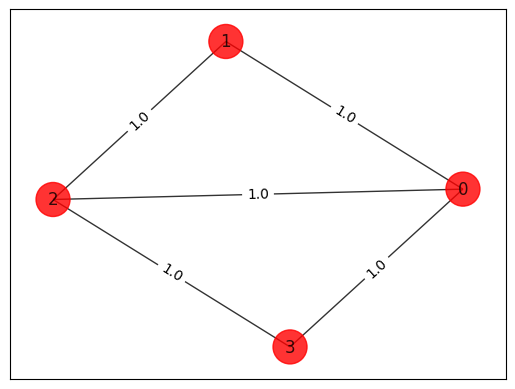

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from functools import partial
from helpers import draw_graph

# Define the problem
n_nodes = 4 
G = nx.Graph()
G.add_nodes_from(np.arange(0, n_nodes, 1).tolist())

# Define the edges of the graph along with their weights
edge_list = [
    (0, 1, 1.0), 
    (0, 2, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
]
G.add_weighted_edges_from(edge_list)

# Set up the visualization
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

# Draw the graph
draw_graph(G, colors, pos)

#### Solving the problem with QAOA (Without circuit cutting)

We can estimate a solution to this problem using the QAOA algorithm.

Cost after step 1: 0.18199999999999994
Cost after step 2: -0.33999999999999997
Cost after step 3: -0.569
Cost after step 4: -0.717
Cost after step 5: -0.641
Cost after step 6: -0.856
Cost after step 7: -0.8390000000000001
Cost after step 8: -0.7530000000000001
Optimal Parameters
[[0.6561625 0.392105 ]
 [0.36342   0.73074  ]]


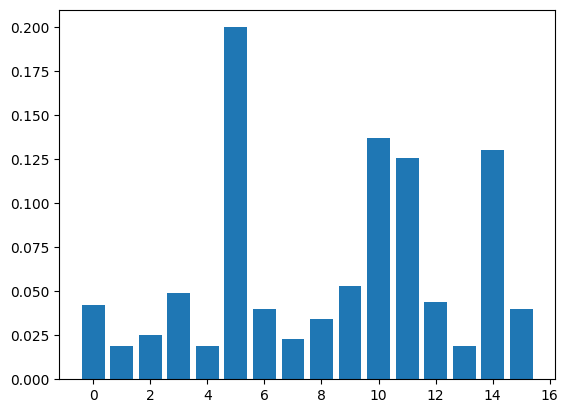

In [12]:
num_qubits = n_nodes


cost_h, mixer_h = qaoa.min_vertex_cover(G, constrained=False)


def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

wires = range(num_qubits)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("default.qubit", wires=n_nodes, shots=1000)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 8
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(f"Cost after step {i + 1}: {cost_function(params)}")

print("Optimal Parameters")
print(params)


@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

# bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

plt.bar(range(2**len(wires)), probs)
plt.show()


As you can see, this problem can be solve using 4 qubits. There is a peak at 5 which represent 0101 in binary. This is the optimal soluton for this problem.

#### Solving the problem with QAOA (Wit circuit cutting)

In this example, we will use the same code as before, but this time, we will reduce the number of qubit (```num_qubits = n_nodes - 1```) needed by using the pennylane auto cutter. This migth not be the optimal solution as it takes time to cut the circuit, but provide a good starting point.

In [ ]:
num_qubits = n_nodes - 1

dev = qml.device("default.qubit", wires=num_qubits, shots=100)


@partial(qml.cut_circuit, auto_cutter=True) 
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 8
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(f"Cost after step {i + 1}: {cost_function(params)}")

print("Optimal Parameters")
print(params)


@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

# bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

plt.bar(range(2**len(wires)), probs)
plt.show()

The circuit using QAOA and the cutting technique took 45 minutes to run on a personnal computer. However, we were able to get the same answer as the one without this technique. This show that the this technique can be use to solve problem with a small number of qubits.

Output : 

![maxcut cutted](./images/maxcut_cutted_parameters.png)

#### Is circuit cutting the holy grail?

Even if circuit cutting is a good idea, it is not always possible to cut a circuit. Indeed, some gates are not "cuttable". For example, during our experiment, we tried to implement the Grover algorithm but it appear that cutting through an oracle migth not be a good idea. The same thing apply for quantum chimestry and VQE as the more you use entanglement, the more you need to keep the qubits together.

### Running on real (fake) hardware (cat qubits)

Cat qubits are a new type of qubits that are not yet available on real quantum devices. They are a mix between qubits and classical bits. They are not entangled and can be used to store information. This is a good way to store the result of a circuit cutting. Indeed, if we can store the result of a circuit cutting, we can then use the result of the first circuit to initialize the second circuit. This is a good way to reduce the number of qubits needed to solve a problem. We waren't able to test the circuit cutting using cat qubits as the simulator take more time. On an average laptop, we estimated that it would take about 8 hours to run without optimization. In this example, we were able to run the problem using only a kappa_1/kappa_2 ratio of 1e-7 and an average of 16 photons (without circuit cutting). Less photons and a higher ratio could have been possible but we didn't had time to perform those tests. To have a best result, we had to reduce the depth of the circuit.

In [ ]:
num_qubits = n_nodes
depth = 1

dev = qml.device("alicebob.qubit", alice_backend="EMU:15Q:LOGICAL_EARLY", wires=num_qubits, average_nb_photons=16, kappa_1=10, kappa_2=1e8)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 8
params = np.array([[0.5], [0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(f"Cost after step {i + 1}: {cost_function(params)}")

print("Optimal Parameters")
print(params)


@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

# bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

plt.bar(range(2**len(wires)), probs)
plt.show()

### Visiting the world and coming back

The traveling salesman problem is a compelling scenario where circuit cutting could prove to be highly beneficial. In instances where cities are grouped into clusters, the connections between these clusters are typically fewer and weaker. These are the strategic points where circuits could be effectively cut, optimizing the overall path and potentially simplifying the problem. During the hackathon, this idea thrived the development, but we were not able to implement it in time. The following code is an example of problem that we created but didn't had time to test the cutting technique. However, even if the problem is similar to maxcut, we beleive that the cutting technique will produce more error because it use the Monte Carlo approximation and there is more entanglement in the circuit.

Here, we create code to solve a problem similar to the Traveling Salesman Problem (TSP), named the ```max weight cycle```, using the Quantum Approximate Optimization Algorithm (QAOA).

The max weight cycle problem involves finding the cycle in a graph that has the maximum total edge weight. The goal is to find the most valuable path that returns to the starting point, where value is measured by the sum of the weights of the edges in the cycle.

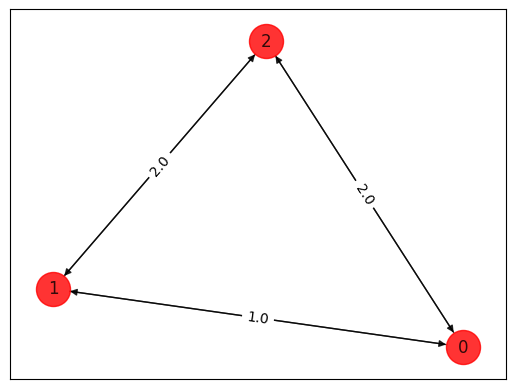

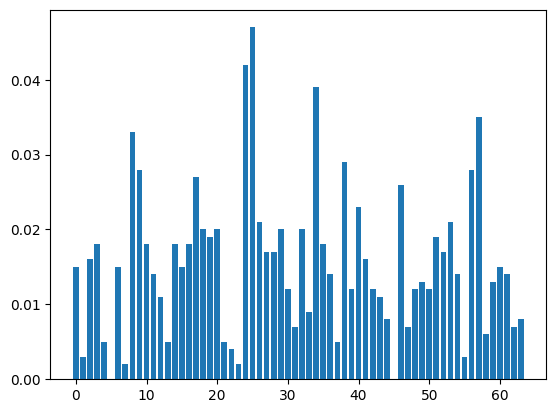

Solution : 


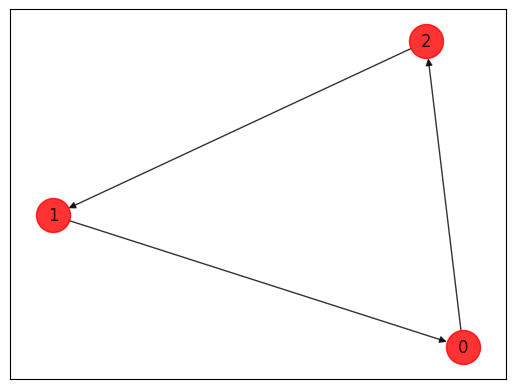

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from functools import partial
from helpers import draw_graph

# Generate a directed graph of 3 nodes with random weights
n_nodes = 3
a = np.random.random((n_nodes, n_nodes)) * 2
np.fill_diagonal(a, 0)
a = np.ceil(a)
np.fill_diagonal(a, 0)

g = nx.DiGraph(a)
cost, mixer, mapping = qml.qaoa.max_weight_cycle(g)

# Draw the graph
draw_graph(g, "r", nx.spring_layout(g))
plt.show()

# Define the QAOA layer
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost)
    qaoa.mixer_layer(alpha, mixer)

# Set the number of qubits and depth of the QAOA circuit
num_qubits = n_nodes * (n_nodes - 1)
wires = range(num_qubits)
depth = 1  # Set depth to 1 to reduce computation time

# Define the QAOA circuit
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

# Initialize the quantum device
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

# Define the cost function
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost)

# Set up the optimizer and initial parameters
optimizer = qml.GradientDescentOptimizer()
steps = 20
params = np.array([[0.5], [0.5]], requires_grad=True)

# Optimize the parameters
for i in range(steps):
    params = optimizer.step(cost_function, params)

# Define a circuit to calculate probabilities
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

# Calculate probabilities of the bitstrings
probs = probability_circuit(params[0], params[1])

# Generate bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

# Plot the probabilities of the bitstrings
plt.bar(range(2 ** len(wires)), probs)
plt.show()

# Find the most likely bitstrings
most_likely = np.argsort(probs)[:-10:-1]
most_likely_top = bitstrings[most_likely[0]]

# Decode the most likely bitstring to a path
all_path = []
for i in range(len(mapping)):
    if most_likely_top[i] == "1":
        all_path.append(mapping[i])

# Create a new graph from the most likely path
print("Solution : ")
G = nx.DiGraph()
G.add_edges_from(all_path)
draw_graph(G, "r", nx.spring_layout(G))
plt.show()


As you can see, the solution of this problem is a circular link between all the nodes. To run the following code with less qubit, you can add the following line of code before the circuit : 
```python
@partial(qml.cut_circuit, auto_cutter=True) 
```

Note that the optimal solution is not always obtain. Increasing the depth or the iteration number migth help to get a better solution each time. We beleive that using circuit cutting would have lead to a similar result as the Maxcut problem but we didn't had time to test this hypothesis and confirm it.

## Conclusion

In the face of the qubit shortage in the ISQ era, pairing circuit cutting with more stable qubit types, such as cat qubits, emerges as a promising strategy to unlock practical quantum computing applications soon. However, the current time it takes to generate circuit cuts using PennyLane is significant. Faster alternatives, like randomized circuit cutting techniques or specialized methods, may be necessary for practical use. Developing examples with PennyLane's circuit cutting can pave the way for a deeper understanding of the potential of this technique.

# Bibliography

Stechly, M. (2019). Solving the Traveling Salesman Problem Using Quantum Computer. Retrieved from https://medium.com/@michal.stechly/solving-the-traveling-salesman-problem-using-quantum-computer-bb00438de223

Qiskit Community. (2024). Examples: Max Cut and TSP. Retrieved from https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html

Xanadu. (Apte, Uchehara, Medvidović, 2022). Tutorial: Quantum Circuit Cutting. Retrieved from https://pennylane.ai/qml/demos/tutorial_quantum_circuit_cutting/.

Draškić, R. (2023, January 17). How to run big quantum circuits on small quantum computers in Pennylane. Xanadu. Retrieved from https://pennylane.ai/blog/2023/01/how-to-run-big-quantum-circuits-on-small-quantum-computers-in-pennylane/

Leonidas, Ioannis D., et al. Qubit efficient quantum algorithms for the vehicle routing problem on NISQ processors. arXiv:2306.08507, arXiv, 19 septembre 2023. arXiv.org, https://doi.org/10.48550/arXiv.2306.08507.

Bechtold, Marvin, et al. « Investigating the effect of circuit cutting in QAOA for the MaxCut problem on NISQ devices ». Quantum Science and Technology, vol. 8, no 4, octobre 2023, p. 045022. arXiv.org, https://doi.org/10.1088/2058-9565/acf59c.